In [4]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data.

In [5]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [6]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

In [7]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

In [8]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## The CCAO Dataset

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

#### What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems?

The Cook County Assessor's Office had a systematic approach of undervaluing more expensive properties and overvaluing less expensive ones. This led to a property tax system that was regressive, meaning that it unfairly burdened less wealthy and non-white property owners with a disproportionate tax liability. One key factor that contributed to this unfair tax system was that wealthier homeowners were able to hire tax lawyers who could contest their tax assessments and successfully lower the assessed value of their property. As a result, these homeowners paid less in taxes compared to the actual value of their property. On the other hand, homeowners with fewer resources did not have the means to contest their assessments in the same manner and were thus unable to reduce their tax liability.



#### In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The property tax system in Cook County placed a disproportionate tax burden on non-white property owners because the undervaluation of more expensive properties and overvaluation of less expensive properties was not uniform across different neighborhoods. The less expensive properties were often located in neighborhoods with higher concentrations of non-white residents. As a result, non-white property owners were more likely to be overtaxed due to the inflated property values assigned to their homes, while more expensive homes owned by white residents were undervalued, leading to a lower tax burden. Therefore, the property tax system was not only regressive but also racially discriminatory, unfairly placing a higher tax burden on non-white property owners.

In [11]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(data_len * 0.8)]
    validation_indices = shuffled_indices[int(data_len * 0.8):]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 2: Fitting a Simple Model

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [13]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def process_data_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bedrooms column
    data = add_total_bedrooms(data)
    # Select X and y from the full data
    X = data[['Bedrooms']]
    y = data['Log Sale Price']
    return X, y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, y_train_m1_simple = process_data_simple(train_m1)
X_valid_m1_simple, y_valid_m1_simple = process_data_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [15]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]

X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, y_valid_m1 = process_data_gm(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by process_data_simple
display(X_train_m1.head())
display(y_train_m1.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [16]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, y_valid_m2 = process_data_gm(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m1_simple.head())
display(y_train_m1_simple.head())

,Bedrooms
130829,4
193890,2
30507,2
91308,2
131132,3


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [18]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

In [19]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, y_train_m1) 
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.predict(X_train_m1) 
y_predicted_m1 = linear_model_m1.predict(X_valid_m1) 

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_valid_m2) 

<br><br>

<hr style="border: 1px solid #fdb515;" />

## Question 3: Evaluate Our Simple Model

<br><br>

--- 

## Question 3a


We are moving into analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error (RMSE) function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in valid set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$


In [21]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [22]:
# Training and validation errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
validation_error_m1 = rmse(y_predicted_m1, y_valid_m1)

# Training and validation errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1)) #
validation_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_valid_m1))


# Training and validation errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
validation_error_m2 = rmse(y_predicted_m2, y_valid_m2)


# Training and validation errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
validation_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_valid_m2)) 

print("1st Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1, validation_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m1_delog, validation_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2, validation_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error_m2_delog, validation_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Validation RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149699024
Validation RMSE: 310679.2486611569

2nd Model
Training RMSE: 0.8042009333446841
Validation RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 325716.40819160367
Validation RMSE: 254880.42228506133



<br><br>

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

In [24]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ_0: {}\nθ_1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ_0: {}\nθ_1: {}\nθ_2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ_0: 10.571725401040084
θ_1: 0.4969197463141442
2nd Model
θ_0: 1.9339633173823696
θ_1: -0.030647249803554506
θ_2: 1.4170991378689644


Text(0.5, 1.0, 'Residuals vs. Original Log Sale Price of the 2nd Model on Test')

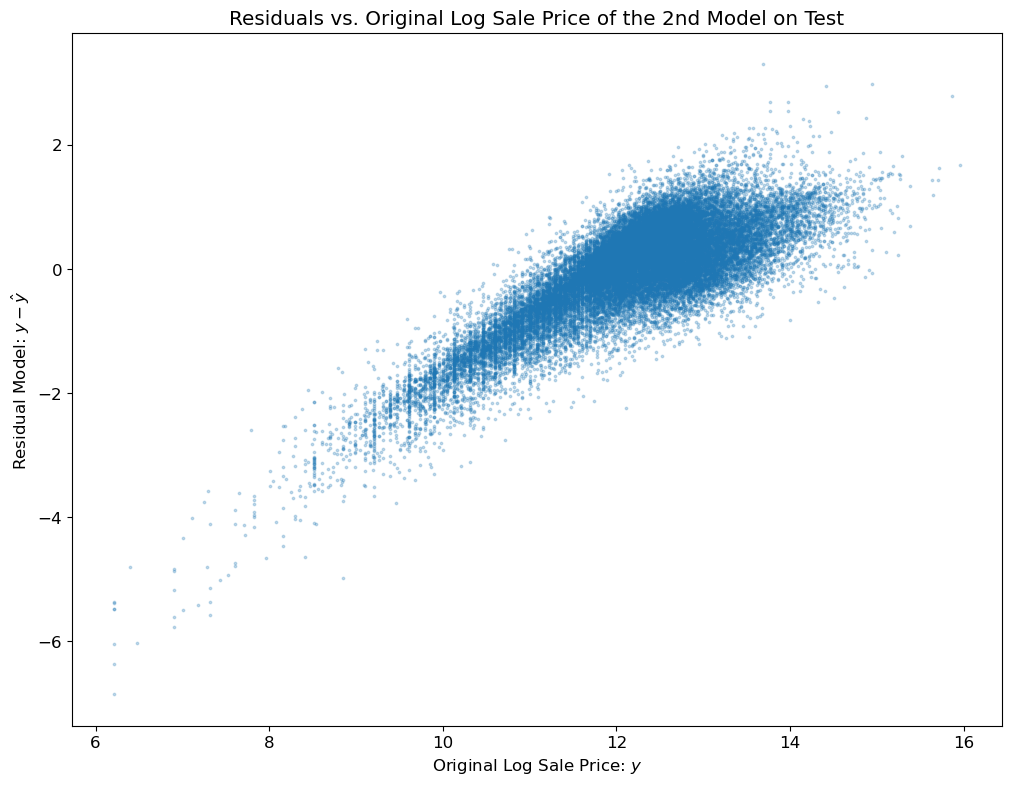

In [25]:
plt.scatter( x=y_valid_m2, y=y_valid_m2 - y_predicted_m2, s=3, alpha=.25)
plt.xlabel('Original Log Sale Price: $y$')
plt.ylabel('Residual Model: $y - \hat{y}$')
plt.title("Residuals vs. Original Log Sale Price of the 2nd Model on Test")

In [44]:
# Uncomment the line below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
# %reset -f
# import otter
# grader = otter.Notebook("projA2.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

from sklearn.preprocessing import OneHotEncoder

In [50]:
# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    data = data.fillna(0)
    data = add_total_bedrooms(data)
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] + 1)
    data["Log Estimate (Land)"] = np.log(data["Estimate (Land)"] + 1)
    data["Root Garage 1 Area"] = np.sqrt(data["Garage 1 Area"])
    data["Root Garage 2 Area"] = np.sqrt(data["Garage 2 Area"])
    data["Square Age"] = np.square(data["Age"])
    data["Log Lot Size"] = np.log(data["Lot Size"])
    data["Square Bedrooms"] = np.square(data["Bedrooms"])
    data = substitute_roof_material(data)
    data = ohe_roof_material(data)
    
    if (is_test_set == False):
        data = remove_outliers(data, variable = "Sale Price", lower = 499, upper = 10 ** 6)
        data["Log Sale Price"] = np.log(data["Sale Price"])
        data = select_columns(data, "Log Sale Price", "Log Building Square Feet", "Log Estimate (Building)", "Log Estimate (Land)", 
                          "Root Garage 1 Area", "Square Age", "Log Lot Size", "Square Bedrooms", 
                          "Floodplain", "Road Proximity")
    else:
        data = select_columns(data, "Log Building Square Feet", "Log Estimate (Building)", "Log Estimate (Land)", 
                          "Root Garage 1 Area",  "Square Age", "Log Lot Size", "Square Bedrooms", 
                          "Floodplain", "Road Proximity")
        
    # Return predictors and response variables separately
    if is_test_set:
        X = data
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 155710.29775574076


When I was creating a model for the data I was working with, I decided to include most of the variables at first, including the roof material variable. To One Hot Encode this variable, I used the OHE function that we had created in a previous part of the project.

However, I soon realized that including too many variables in the model could potentially lead to overfitting or inaccuracies in the model's predictions. To avoid this, I decided to run the code to identify which variables had the most data points that were close to 0. This would help me determine which variables were contributing little to no information to the model and could potentially be removed without affecting the model's accuracy.

After identifying these variables, I removed them from the model, assuming that doing so would have little to no effect on the model's predictions. This step allowed me to reduce the number of variables in the model and improve its overall efficiency.

I also observed that for some of the remaining variables, they did not have a linear relationship with the sale price. To address this, I applied logarithmic and squared transformations to these variables, depending on their general shape. This would help me better capture the non-linear relationship between these variables and the sale price, and improve the accuracy of the model's predictions.

When evaluating houses, "error" refers to the difference between the actual market value or sale price and the value determined by the CCAO. If the error is positive, it means the property is undervalued, resulting in lower property taxes. On the other hand, a negative error means the property is overvalued, leading to higher property taxes.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


To define fairness in property assessments and taxes, it is important to ensure that assessments and taxes accurately reflect the value of the property and are distributed equitably among property owners. The system should be transparent, consistent, and equitable for all property owners.

<!-- END QUESTION -->

## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.

The documentation may seem hard to understand for nontechnical audiences in terms of terminology, the documentation use technical terms such as regularized linear model and over-fitting. Also, the documentation assumes that the audience have a knowledge of certain concepts, such as statistics, that may not be universally understood.

To make the documentation more accessible to nontechnical audiences, it may be helpful to provide definitions of technical terms, explanations of key concepts, and visual aids to help illustrate the model and its outputs. Additionally, using plain language will also help make the documentation more understandable.

<!-- END QUESTION -->

You might feel that the model's inner workings are beyond your pay grade - it's far more complex than the model you built in this assignment, after all! Though we won't delve further into the role of transparency in the broader CCAO case study, consider its effectiveness and/or ineffectiveness: Is the system truly transparent if it's inaccessible to Cook County constituents? Do transparency measures actually bolster the accuracy of a model - or do they only affect the _perceived_ accuracy of a model? 

And if you're interested in thinking more about transparency measures, take Data 104! But for now...